## _Track Building (Reco.) from GNN Score_

- after GNN Stage, one has evaluation (_**i.e.** edge score_) of GNN on test data.
- the GNN evaluation data (_**i.e.** edge score_) is stored in _`run/gnn_evaluation/test`_.
- use _`trkx_from_gnn.py`_ to reconstruct tracks saved to _`run/trkx_from_gnn`_ folder.

Following the breakdown of _`trkx_from_gnn.py`_ script.

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import time

In [4]:
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial

In [5]:
# select a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# functions from draw_utils for drawing
from LightningModules.Processing.utils.draw_utils import draw_proc_event, cylindrical_to_cartesian

In [7]:
# functions from tracks_from_gnn.py scripts
from trkx_from_gnn import tracks_from_gnn

### _(1) Processed Data_

In [8]:
inputdir="run/feature_store/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))
proc_files[:5]

['run/feature_store/test/900',
 'run/feature_store/test/901',
 'run/feature_store/test/902',
 'run/feature_store/test/903',
 'run/feature_store/test/904']

In [9]:
feature_data = torch.load(proc_files[1], map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 10


In [10]:
# event ID
event_id = int(os.path.basename(feature_data.event_file)[-10:])
print("Event ID: {}".format(event_id))

Event ID: 901


In [11]:
# number of tracks
track_ids = np.unique(feature_data.pid)
print("Track IDs: {}".format(track_ids))

Track IDs: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


### _(2) GNN Evaluation Data_

In [12]:
inputdir="run/gnn_evaluation/test"
gnn_eval_files = sorted(glob.glob(os.path.join(inputdir, "*")))
gnn_eval_files[:5]

['run/gnn_evaluation/test/0900',
 'run/gnn_evaluation/test/0901',
 'run/gnn_evaluation/test/0902',
 'run/gnn_evaluation/test/0903',
 'run/gnn_evaluation/test/0904']

In [13]:
gnn_eval_data = torch.load(gnn_eval_files[1], map_location=device)
print("Length of Data: {}".format(len(gnn_eval_data)))

Length of Data: 11


In [14]:
# event ID
event_id = int(os.path.basename(gnn_eval_data.event_file)[-10:])
print("Event ID: {}".format(event_id))

Event ID: 901


In [15]:
# number of tracks
track_ids = np.unique(gnn_eval_data.pid)
print("Track IDs: {}".format(track_ids))

Track IDs: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [16]:
# evaluation score (only first 5 edge scores)
scores = gnn_eval_data.scores[:5].numpy()
print("Evaluation/Edge Score: {}".format(scores))

Evaluation/Edge Score: [6.5537709e-01 6.5540063e-01 2.3878885e-04 2.4712211e-04 3.1676106e-04]


### _(3) Tracks from GNN_

- We have everything in _`run/gnn_evaluation/test`_, _**i.e.**_ input feature data (from Processing Stage) and evaluation score (from GNN Stage).
- The _score_ from GNN Stage is also called the _edge score_ or _evaluation score_, etc.

Here is breakdown of _`tracks_from_gnn.py`_ script.

In [17]:
# Input dir from GNN Evaluation (GNN Test Step)
inputdir="run/gnn_evaluation/test"

In [18]:
# Output dir for Track Building/Reco
outputdir = "run/trkx_from_gnn"
os.makedirs(outputdir, exist_ok=True)

In [19]:
# GNN Evaluation Data

# use os.listdir to fetch files
# all_events = os.listdir(inputdir) # get a list of files
# all_events = sorted([os.path.join(inputdir, event) for event in all_events]) # list-comprehension to join path with files & sort
# all_events[:10]

In [20]:
# GNN Evaluation Data

# use glob.glob to fetch files (Note: glob.glob is wrapper around os.listdir)
gnn_eval_files = sorted(glob.glob(os.path.join(inputdir, "*")))
gnn_eval_files[:10]

['run/gnn_evaluation/test/0900',
 'run/gnn_evaluation/test/0901',
 'run/gnn_evaluation/test/0902',
 'run/gnn_evaluation/test/0903',
 'run/gnn_evaluation/test/0904',
 'run/gnn_evaluation/test/0905',
 'run/gnn_evaluation/test/0906',
 'run/gnn_evaluation/test/0907',
 'run/gnn_evaluation/test/0908',
 'run/gnn_evaluation/test/0909']

In [21]:
gnn_eval_data = torch.load(gnn_eval_files[1], map_location=device)
print("Length of Data: {}".format(len(gnn_eval_data)))

Length of Data: 11


In [22]:
# input to GNN (processed data)
feature_data

Data(x=[168, 3], pid=[168], layers=[168], event_file='/home/adeak977/current/3_deeptrkx/stttrkx-hsf/train_all/event0000000901', hid=[168], pt=[168], modulewise_true_edges=[2, 158], layerwise_true_edges=[2, 166], edge_index=[2, 816], y_pid=[816])

In [23]:
# output from GNN (evaluated data)
gnn_eval_data

Data(x=[168, 3], pid=[168], layers=[168], event_file='/home/adeak977/current/3_deeptrkx/stttrkx-hsf/train_all/event0000000901', hid=[168], pt=[168], modulewise_true_edges=[2, 158], layerwise_true_edges=[2, 166], edge_index=[2, 816], y_pid=[816], scores=[1632])

In [24]:
gnn_eval_data.edge_index

tensor([[  0,   0,   0,  ..., 167, 167, 167],
        [  8,   9,  15,  ..., 156, 158, 165]])

In [25]:
gnn_eval_data.edge_index.flip(0)

tensor([[  8,   9,  15,  ..., 156, 158, 165],
        [  0,   0,   0,  ..., 167, 167, 167]])

In [26]:
gnn_eval_data.scores

tensor([6.5538e-01, 6.5540e-01, 2.3879e-04,  ..., 1.8170e-04, 9.8129e-03,
        1.7529e-04])

In [27]:
# process(): input params
max_evts = 100
n_tot_files = len(gnn_eval_files)
max_evts = max_evts if max_evts > 0 and max_evts <= n_tot_files else n_tot_files

In [28]:
# process(): prepare data for tracks_from_gnn()
score = gnn_eval_data.scores[:gnn_eval_data.edge_index.shape[1]]
senders = gnn_eval_data.edge_index[0]
receivers = gnn_eval_data.edge_index[1]
hit_id = gnn_eval_data.hid

In [29]:
score.shape

torch.Size([816])

In [30]:
senders.shape

torch.Size([816])

In [31]:
receivers.shape

torch.Size([816])

In [32]:
hit_id.shape

torch.Size([168])

### _Plotting Events_

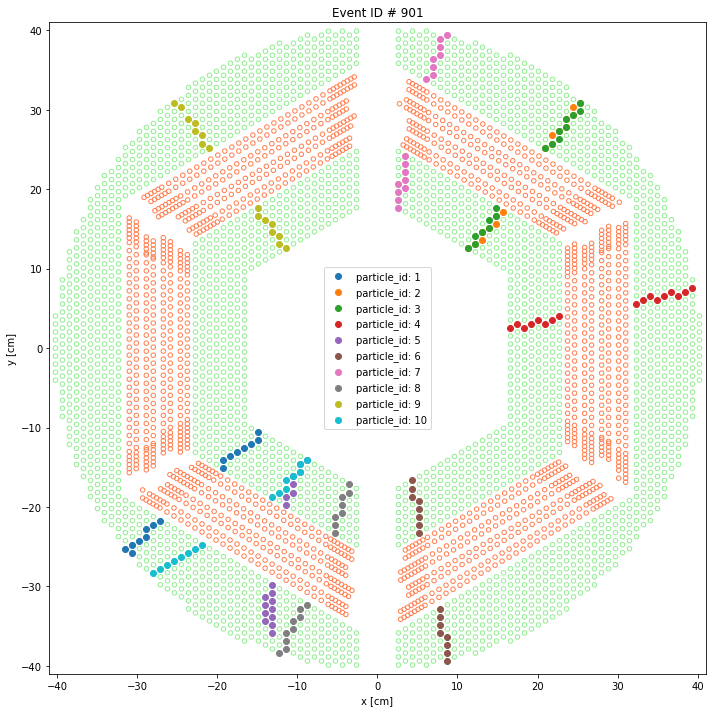

In [33]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=gnn_eval_data.x[:, 0].detach().numpy(),
                                 phi=gnn_eval_data.x[:, 1].detach().numpy(),
                                 z=gnn_eval_data.x[:, 2].detach().numpy())
    
# particle track(s)
pids = np.unique(gnn_eval_data.pid)
for pid in pids:
    idx = gnn_eval_data.pid == pid
    ax.scatter(x[idx], y[idx], label='particle_id: %d' %pid)


# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

In [34]:
# predicted/reco tracks using DBSCAN
reco_tracks = tracks_from_gnn(hit_id, score, senders, receivers, edge_score_cut=0.25, epsilon=0.25, min_samples=2)

/shared/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [35]:
# let fetch hit_ids of a track, e.g. track_id == 
reco_tracks.query("track_id==-1")

,hit_id,track_id
0,1,-1
1,123,-1
3,175,-1
4,200,-1
8,2,-1
9,124,-1
13,201,-1
14,176,-1
17,3,-1
18,125,-1


pid:  -1
pid:  0
pid:  1
pid:  2
pid:  3
pid:  4
pid:  5
pid:  6
pid:  7
pid:  8


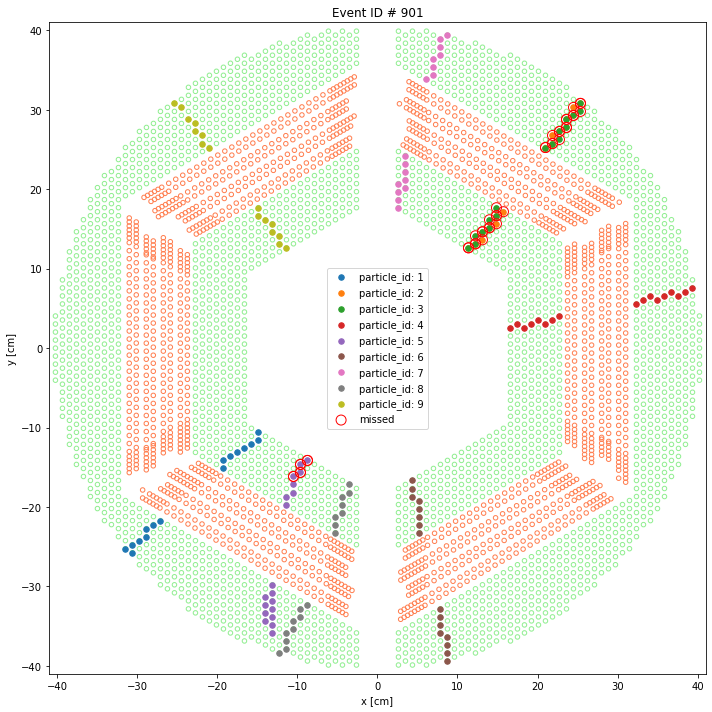

In [36]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=gnn_eval_data.x[:, 0].detach().numpy(),
                                 phi=gnn_eval_data.x[:, 1].detach().numpy(),
                                 z=gnn_eval_data.x[:, 2].detach().numpy())

# reco track(s)
pids = np.unique(reco_tracks.track_id)
for pid in pids:
    print("pid: ", pid)
    idx = gnn_eval_data.pid == (pid+1)
    if pid >= 0:
        ax.scatter(x[idx], y[idx], s=30, label='particle_id: %d' %(pid+1))

# Missed hits
missed_hids= reco_tracks.query("track_id==-1")["hit_id"].values
hids = gnn_eval_data.hid.numpy()
idx = np.where(np.isin(hids, missed_hids))[0]
ax.scatter(x[idx], y[idx], facecolors='none', edgecolors='red', s=100, linewidth=1, label='missed')

# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

In [37]:
np.unique(reco_tracks.track_id.values)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [38]:
missed_hid = reco_tracks.query("track_id==-1")["hit_id"]
missed_hids = missed_hid.values

In [39]:
missed_hids

array([  1, 123, 175, 200,   2, 124, 201, 176,   3, 125, 177, 202,   4,
       126, 178, 203, 179, 204, 180, 205, 206, 181, 182, 207, 216, 191,
       217, 192, 218, 193, 194, 219, 195, 220, 221, 196, 222, 197, 223,
       198, 224, 199], dtype=int32)

In [40]:
gnn_eval_data.hid

tensor([  1, 123, 150, 175, 200,  25,  99,  49,   2, 124, 151,  74,  26, 201,
        176, 100, 225,   3, 125,  50, 152,  27, 177,  75, 226, 202, 101,  51,
          4, 126, 153, 178,  28, 203, 227,  76, 102, 127,   5,  52,  29, 154,
         77, 179, 204, 228,  78, 103, 128,   6,  53, 155,  30, 180,  79, 205,
         54, 104, 229, 129,   7, 156, 206, 181,  31,  80, 130, 105,  55,   8,
        230, 157, 182,  32, 207,  81, 106,  56, 231,  82, 232, 139, 166,  41,
        216, 191,  17,  65, 140, 115, 217, 192,  42, 167,  18,  66, 141,  91,
        142, 218,  43, 168, 193, 116, 243,  19,  92,  67, 143, 144, 169,  44,
        194, 219, 117, 244,  68,  20,  93, 145,  45, 146, 195, 220, 170, 118,
        245,  69,  21,  94, 147, 221, 196,  46, 148, 246, 119, 171,  70,  95,
         22, 222, 197, 149, 172, 247, 120,  71,  96,  23, 223,  47, 198, 173,
        248, 121,  72,  97,  24,  48, 224, 199, 249, 174,  73, 122,  98, 250],
       dtype=torch.int32)

In [41]:
hids = gnn_eval_data.hid.numpy()

In [42]:
# let get indices of missed_hids in hids
idx = np.where(np.isin(hids, missed_hids))[0]

## Fixing the Srcipt using above EDA

NOTE: The script `tracks_from_gnn.py` is taken from the `exatrkx-iml2020/exatrkx/scripts` repository. It needs to be fixed according to `exatrkx-hsf` repo. 

Above disection of this script provides info on how to make it compatible with the `exatrkx-hsf` pipeline.

- **_Keep_**: _`tracks_from_gnn()`_
- **_Modify_**: _`process()`_
- **_Modify_**: _`__main__`_

In [43]:
# tracks_from_gnn() declared above

In [44]:
# Input/Output Data. Get Data from test Folder.
inputdir="run/gnn_evaluation/test"
outputdir = "run/trkx_from_gnn"
os.makedirs(outputdir, exist_ok=True)

In [45]:
# use os.listdir(path) to fetch files in arbitrary order
all_events = os.listdir(inputdir) # only list of files in arbitrary order
all_events = [os.path.join(inputdir, event) for event in all_events] # join path+files as a list
all_events = sorted(all_events) # sorted() over list/tuple iterator
all_events[:10]

['run/gnn_evaluation/test/0900',
 'run/gnn_evaluation/test/0901',
 'run/gnn_evaluation/test/0902',
 'run/gnn_evaluation/test/0903',
 'run/gnn_evaluation/test/0904',
 'run/gnn_evaluation/test/0905',
 'run/gnn_evaluation/test/0906',
 'run/gnn_evaluation/test/0907',
 'run/gnn_evaluation/test/0908',
 'run/gnn_evaluation/test/0909']

In [46]:
# OR, use glob.glob to fetch files (Note: glob.glob is wrapper around os.listdir)
all_files = glob.glob(os.path.join(inputdir, "*")) # list of files with path in arbitrary order
all_files = sorted(all_files) # sorted() over list/tuple iterator
all_files[:10]

['run/gnn_evaluation/test/0900',
 'run/gnn_evaluation/test/0901',
 'run/gnn_evaluation/test/0902',
 'run/gnn_evaluation/test/0903',
 'run/gnn_evaluation/test/0904',
 'run/gnn_evaluation/test/0905',
 'run/gnn_evaluation/test/0906',
 'run/gnn_evaluation/test/0907',
 'run/gnn_evaluation/test/0908',
 'run/gnn_evaluation/test/0909']

In [47]:
max_evts = 100
n_tot_files = len(all_files)
max_evts = max_evts if max_evts > 0 and max_evts <= n_tot_files else n_tot_files

In [48]:
# Let Peep into a Event
fname = all_files[0]

In [49]:
int(os.path.basename(fname))

900

In [50]:
evtid = int(os.path.basename(fname))

In [51]:
print("event_id: {}".format(evtid))

event_id: 900


In [52]:
# Load Event
gnn_data = torch.load(fname)
print("Length of Data: {}".format(len(gnn_data)))

Length of Data: 11


In [53]:
gnn_data.scores.shape[0]/2

946.0

In [54]:
# Get score, edge pair (sender, receiver) and hit_id from the Event
score = gnn_data.scores[:gnn_data.edge_index.shape[1]]
senders = gnn_data.edge_index[0]
receivers = gnn_data.edge_index[1]
hit_id = gnn_data.hid

In [55]:
def process(filename, outdir, score_name, **kwargs):
    """prepare a multiprocessing function for track building"""
    
    # get the event_id from the filename
    #evtid = int(os.path.basename(filename))  # [:-4] was to skip .npz extension, skipped in my case.
    evtid = os.path.basename(filename)
    
    # gnn_prcessed data by GNNBuilder Callback
    gnn_data = torch.load(filename)
    score = gnn_data.scores[:gnn_data.edge_index.shape[1]] # scores has twice the size of edge_index (flip(0) was used)
    senders = gnn_data.edge_index[0]
    receivers = gnn_data.edge_index[1]
    hit_id = gnn_data.hid
    
    # predicted tracks from the GNN stage
    predicted_tracks = tracks_from_gnn(hit_id, score, senders, receivers, **kwargs)
 
    # save reconstructed tracks into a file
    # PyTorch convention is to save tensors using .pt file extension
    # See https://pytorch.org/docs/stable/notes/serialization.html#preserve-storage-sharing
    torch.save(predicted_tracks, os.path.join(outdir, "{}.pt".format(evtid)))

In [56]:
# after success move to gnn_trkx.py
process(fname, outputdir, "scores")

/shared/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
